# reach_analysis_B.ipynb

Parallel version of reach_analysis_A.

Learn to reach, perform radial reaches, and do the analyses that concern the characteristics of the reach.

In [1]:
%cd /home/z/projects/draculab/

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
#from tools.visualization import plotter
from multiprocessing import Pool
import copy
import pickle

In [3]:
from pathos.multiprocessing import ProcessingPool

In [4]:
%cd ./notebook/spinal/
#%cd /home/z/projects/draculab/notebook/spinal/
from v3ft3p2ph2_net import *
%cd ../..

/home/z/projects/draculab/notebook/spinal
/home/z/projects/draculab


In [5]:
# load parameter configurations
import pickle
fname = '/home/z/Dropbox (OIST)/saves/gene_2021-06-17'
with (open(fname, "rb")) as f:
    pop_gene17 = pickle.load(f)
    f.close()
# fname = '/home/z/Dropbox (OIST)/saves/pso_2021-06-17'
# with (open(fname, "rb")) as f:
#     pop_pso17 = pickle.load(f)
#     f.close()
fname = '/home/z/Dropbox (OIST)/saves/pso_2021-08-25'
with (open(fname, "rb")) as f:
    pop_gene25 = pickle.load(f)
    f.close()
fname = '/home/z/Dropbox (OIST)/saves/gene_2021-07-19'
with (open(fname, "rb")) as f:
    pop_gene19 = pickle.load(f)
    f.close()
fname = '/home/z/Dropbox (OIST)/saves/pso_2021-06-28'
with (open(fname, "rb")) as f:
    pop_pso28 = pickle.load(f)
    f.close()
fname = '/home/z/Dropbox (OIST)/saves/reach_anaB_2021-07-08'
with (open(fname, "rb")) as f:
    pop_rab08 = pickle.load(f)
    f.close()

In [5]:
# Set parameters directly
# cfg_syne={'A__M_lrate': 20.0,
#      'A__M_w_max_frac': 0.33,
#      'A__M_w_sum': 1.0,
#      'AL_thresh': 0.55,
#      'b_e': 1.1,
#      'C__C_antag': 1.7,
#      'C__C_p_antag': 0.27,
#      'C__C_p_syne': 0.33,
#      'C__C_syne': 1.13,
#      'C_adapt_amp': 0.,
#      'C_cid': 0.15,
#      'C_sigma': 0.47,
#      'C_slope': 2.26,
#      'C_tau': 0.22,
#      'C_tau_slow': 2.0,
#      'C_thresh': 1.05,
#      'CE__CI_w': 0.38,
#      'CI__CE_w': -1.89,
#      'g_e_03': 21.1,
#      'CI_slope': 3.8,
#      'CI_tau': 0.025,
#      'CI_thresh': 1.34,
#      'g_e_factor': 3.07,
#      'II_g_03': 2.9,
#      'M__C_lrate': 500.,
#      'M__C_w_sum': 3.4,
#      'M__M_w': 0.0,
#      'M_cid': 1.1,
#      'M_des_out_w_abs_sum': 2.,
#      'M_tau': 0.033,
#      'SF_thresh_03': 0.55,
#      'SPF__SPF_w': -1.77,
#      'fitness': None,
#      'n_evals': 0,
#      't_pres': 40.,
#      'par_heter': 0.01}

cfg_std={'A__M_lrate': 20.0,
     'A__M_w_max_frac': 0.34,
     'A__M_w_sum': 1.0,
     'AL_thresh': 0.56,
     'b_e': 1.,
     'C__C_antag': 1.6,
     'C__C_p_antag': 0.15,
     'C__C_p_syne': 0.26,
     'C__C_syne': 1.1,
     'C_adapt_amp': 0.0,
     'C_cid': 0.17,
     'C_sigma': 0.5,
     'C_slope': 2.25,
     'C_tau': 0.24,
     'C_tau_slow': 2.0,
     'C_thresh': 1.14,
     'CE__CI_w': 0.39,
     'CI__CE_w': -1.8,
     'g_e_03': 20.,
     'CI_slope': 3.9,
     'CI_tau': 0.06,
     'CI_thresh': 1.37,
     'g_e_factor': 3.,
     'II_g_03': 2.73,
     'M__C_lrate': 500.0,
     'M__C_w_sum': 3.28,
     'M__M_w': 0.0,
     'M_cid': 1.,
     'M_des_out_w_abs_sum': 1.87,
     'M_tau': 0.012,
     'SF_thresh_03': 0.59,
     'SPF__SPF_w': -1.6,
     'fitness': None,
     'n_evals': 0,
     't_pres': 40.,
     'par_heter': 0.01}
cfg_syne = cfg_std

In [6]:
# Create configurations for the simulations
#np.random.seed(123456) # always the same random values
#np.random.seed() # arbitrary random seed

n_reps_per_dict = 20 # how many times to test each configuration

# cfg_list = [pop_gene17[0], pop_gene17[1],
#            pop_gene19[0], pop_gene19[1],
#            pop_pso28[0], pop_pso28[1],
#            pop_gene25[0], pop_gene25[1]]
            

cfg_list = [cfg_std] #, cfg_syne]

new_gain_vals = [1., 1.5]
new_noise_vals = [0.]
r_vals = [0.1]
use_syne_l = [False, True]
monoarticular = [False]
rot_SPF = [True, False]
#n_configs1 = len(new_gain_vals)*len(new_noise_vals)*len(r_vals)
n_configs1 = len(new_gain_vals)*len(new_noise_vals)*len(use_syne_l)*len(monoarticular)*len(rot_SPF)
#varis = []
arg_dicts = []

basic_dict_std = {'n_reaches_l':16,
                  'use_syne':False,
                  'set_C_delay':False,
                  'rand_targets':True,
                  'C_noise':True,
                  'M__C_rand_w':True,
                  'permute_targets':True,
                  'new_noise':0.,
                  'new_gain':1.,
                  't_pres':5.,
                  'n_rounds':6,
                  'r':0.1,
                  't_smp':4.,
                  'rot_SPF':False}

basic_dict_syne = {'n_reaches_l':16,
                  'use_syne':True,
                  'set_C_delay':False,
                  'rand_targets':True,
                  'C_noise':True,
                  'M__C_rand_w':True,
                  'permute_targets':True,
                  'new_noise':0.,
                  'new_gain':1.,
                  't_pres':5.,
                  'n_rounds':6,
                  'r':0.1,
                  't_smp':4.,
                  'rot_SPF':False}

# for new_gain in new_gain_vals:
#     for new_noise in new_noise_vals:
#         for r in r_vals:
#             conf = basic_dict.copy()
#             conf['new_gain'] = new_gain
#             conf['new_noise'] = new_noise
#             conf['r'] = r
#             varis.append(conf)

# for cfg in cfg_list:
#     for var_dict in varis:
#         cfgd = {'cfg':cfg}
#         cfgd.update(var_dict)
#         arg_dicts.append(cfgd.copy())
#         cfgd['use_syne'] = True
#         arg_dicts.append(cfgd)


# for new_gain in new_gain_vals:
#     for new_noise in new_noise_vals:
#         for mono in monoarticular:
#             for syne in use_syne_l:
#                 for r_SPF in rot_SPF:
#                     if syne:
#                         conf = basic_dict_syne.copy()
#                         cfg = cfg_syne.copy()
#                     else:
#                         conf = basic_dict_std.copy()
#                         cfg = cfg_std.copy()
#                     if mono:
#                         cfg['k_pe_e'] = [0.1, 20., 20., .1, 20., 20.]
#                         cfg['k_se_e'] = [0.1, 20., 20., .1, 20., 20.]
#                         cfg['g_e_03'] = 0.01
#                     conf['new_gain'] = new_gain
#                     conf['new_noise'] = new_noise
#                     conf['rot_SPF'] = r_SPF
#                     #conf['r'] = r
#                     conf.update({'cfg':cfg})
#                     arg_dicts.append(conf)            

for new_gain in new_gain_vals:
    for cfg in cfg_list:
        for r_SPF in rot_SPF:
            for syne in use_syne_l:
                if syne:
                    conf = basic_dict_syne.copy()
                else:
                    conf = basic_dict_std.copy()
                conf['new_gain'] = new_gain
                conf['rot_SPF'] = r_SPF
                conf.update({'cfg':copy.deepcopy(cfg)})
                arg_dicts.append(conf)            

all_arg_dicts = []
for arg_dict in arg_dicts:
    all_arg_dicts += n_reps_per_dict*[arg_dict]

In [6]:
# Create configurations for debugging
#np.random.seed(123456) # always the same random values
np.random.seed() # arbitrary random seed

n_reps_per_dict = 5 # how many times to test each configuration

cfg_list = [cfg_std, cfg_syne]

new_gain_vals = [1.]
new_noise_vals = [0.]
r_vals = [0.1]
use_syne_l = [False]
monoarticular = [False]
rot_SPF = [True]
#n_configs1 = len(new_gain_vals)*len(new_noise_vals)*len(r_vals)
n_configs1 = len(new_gain_vals)*len(new_noise_vals)*len(use_syne_l)*len(monoarticular)*len(rot_SPF)
#varis = []
arg_dicts = []

basic_dict_std = {'n_reaches_l':16,
                  'use_syne':False,
                  'set_C_delay':False,
                  'rand_targets':True,
                  'C_noise':True,
                  'M__C_rand_w':True,
                  'permute_targets':True,
                  'new_noise':0.,
                  'new_gain':1.,
                  't_pres':5.,
                  'n_rounds':6,
                  'r':0.1,
                  't_smp':4.,
                  'rot_SPF':False}

basic_dict_syne = {'n_reaches_l':16,
                  'use_syne':True,
                  'set_C_delay':False,
                  'rand_targets':True,
                  'C_noise':True,
                  'M__C_rand_w':True,
                  'permute_targets':True,
                  'new_noise':0.,
                  'new_gain':1.,
                  't_pres':5.,
                  'n_rounds':6,
                  'r':0.1,
                  't_smp':4.,
                  'rot_SPF':False}

for new_gain in new_gain_vals:
    for new_noise in new_noise_vals:
        for mono in monoarticular:
            for syne in use_syne_l:
                for r_SPF in rot_SPF:
                    if syne:
                        conf = basic_dict_syne.copy()
                        cfg = cfg_syne.copy()
                    else:
                        conf = basic_dict_std.copy()
                        cfg = cfg_std.copy()
                    if mono:
                        cfg['k_pe_e'] = [0.1, 20., 20., .1, 20., 20.]
                        cfg['k_se_e'] = [0.1, 20., 20., .1, 20., 20.]
                        cfg['g_e_03'] = 0.01
                    conf['new_gain'] = new_gain
                    conf['new_noise'] = new_noise
                    conf['rot_SPF'] = r_SPF
                    #conf['r'] = r
                    conf.update({'cfg':cfg})
                    arg_dicts.append(conf)            
            
all_arg_dicts = []
for arg_dict in arg_dicts:
    all_arg_dicts += n_reps_per_dict*[arg_dict]

In [7]:
def set_new_targets(net,
                    pops_dict,
                    r,
                    t_pres,
                    n_trgs,
                    n_rounds,
                    pds,
                    permute_targets=True):
    """ Set new targets for reaching.
        
        Args:
            net: the draculab network
            pops_dict: dictionary with unit IDs for each population
            r: distance from center to targets 
            t_pres: new presentation time
            n_trgs: number of targets
            n_rounds: number of times the n_trgs targets will be presented
            pds : parameter dictionaries used to calculate SP values.
            permute_targets: (boolean) are targets presented permuted?
            
        Returns:
            hand_coords : list with target coordinates (each a numpy 2-array).
            targets : list, only with targets
            center : only the center coordinates
            trg_ids: target used for each presentation
            m_idxs: indexes in 'hand_coords' for the sequence of targets
    """
    
    start_t = net.sim_time # starting time for new simulation
    # 8 radial targets in sequence, from 0 to 315 degrees
    center = np.array([0.3, 0.3]) # initial hand location
    angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
    circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
    targets = center + r*circle # coordinates of the targets

    if permute_targets:
        # version with permuted targets, all are seen every 8 presentations
        trg_ids = np.random.permutation(n_trgs*n_rounds)%8 # target for each presentation
        hand_coords = []
        for idx in trg_ids:
            hand_coords += [center, targets[idx]]
        hand_coords += [center] # to avoid indexes out of bounds
    else:    
        # version with sequential targets
        hand_coords = [center, targets[0],
                       center, targets[1],
                       center, targets[2],
                       center, targets[3],
                       center, targets[4],
                       center, targets[5],
                       center, targets[6],
                       center, targets[7]]
        hand_coords = n_rounds * hand_coords # many repetitions of the same sequence
        hand_coords += [center] # to avoid indexes out of bounds
        trg_ids = np.arange(len(hand_coords))%8 # target for each presentation

    SP = pops_dict['SP']
    A = pops_dict['A']
    P = pops_dict['P']
    #### next is a copy-pasta of the code to set the SP values
    # list with muscle lengths corresponding to the hand coordinates
    m_lengths = []
    for coord in hand_coords:
        m_lengths.append(net.plants[P].coords_to_lengths(coord))
    m_lengths = np.array(m_lengths)
    #(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
    # We need to translate these lengths to corresponding SF activity levels.
    # For that it is necessary to recreate all their transformations
    # The first transformation is from length to II afferent activity.
    ### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
    par = net.plants[P].m_params
    # steady state tensions in the static and dynamic bag fibers (no gamma inputs)
    Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
             par['k_pe_s']*(m_lengths - par['l0_s']))
    Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
             par['k_pe_d']*(m_lengths - par['l0_d']))
    # steady state afferent outputs (no gamma inputs)
    #Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
    II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
    #Ia_ss *= par['Ia_gain']
    II_ss *= par['II_gain']
    #Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
    # Next transformation is through the afferent units
    P__A_ws = np.array(pds['P__A_syn']['init_w'][12:18])
    #Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
    # target averages
    A_thr = np.array([net.units[u].thresh for u in A[12:18]])
    A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
    #(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
    # Next is from A to SF
    SF_arg = pds['A__SF_syn']['init_w']*A_II
    SF_params = pds['SF_params']
    SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
    SF_params['init_val'] = SF_out # this might cause a smooth start
    # now we set the values in SP
    #m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    m_idxs = list(range(len(hand_coords)+1)) # reach list targets sequentially
        #m_idxs[0] = 0 # for testing
    A_us = [net.units[u] for u in A]

    def SF_sigmo(idx, arg):
        """ The sigmoidal function for SF unit with index SF[idx]. """
        return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

    def cur_target(t):
        """ Returns the index of the target at time t. """
        return m_idxs[int(np.floor((t-start_t)/t_pres))]

    def make_fun(idx):
        """ create a function for the SP unit with index 'idx'. """
        return lambda t: SF_sigmo(idx, 
                            pds['A__SF_syn']['init_w'][idx] * (
                            np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                            net.units[A[12+idx]].thresh, 0.))))

    for idx, u in enumerate(SP):
        net.units[u].set_function(make_fun(idx))
        
    return hand_coords, targets, center, trg_ids, m_idxs

In [8]:
# Functions to arrange the multiunit data from the various reaches
def get_tensor(series, J, K, T, trg_ids):
    """ Given a simulation time series, arrange it by reach and repetition.
    
        Args:
            series : a time series, spanning simtime2 seconds, in min_delay steps.
            J : number of targets in the simulation.
            K : number of repetitions of each target.
            T : number of time steps that each target is presented.
            
        Returns:
            tensor : a 3-dimensional array. tensor(j,k,t) is the value of the series
                     for target j, on the k-th repetition, at time step t. Time steps
                     begin anew for each reach.
    """
    tensor = np.zeros((J, K, T))
    trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled

    for reach, trg in enumerate(trg_ids):
        init_tid = (1 + 2 * reach) * T
        final_tid = init_tid + T # t_pres seconds later
        tensor[trg, trg_reps[trg],:] = series[init_tid:final_tid]
        trg_reps[trg] += 1
        
    return tensor

def get_pop_tensor(pop, J, K, T, t_strt, t_pres, trg_ids, data, md):
    """ Returns a tensor with the activities in a population arranged by target and repetition.
    
        Args:
            pop : a list with the IDs of the populations units in the 'data' matrix.
            J : number of targets in the simulation.
            K : number of repetitions of each target.
            T : number of time points to sample per reach (min_delay units)
            t_pres : time that a full reach lasts (seconds)
            t_strt : time after target onset when sample begins (seconds)
            trg_ids : trg_ids[i] is the target at the i-th reach
            data: the simulation data (unit activities)
            md : network time step (e.g. net.min_delay)
        Returns:
            tensor : a 4-dimensional array. tensor(i,j,k,t) is the activity of the i-th
                     unit, when reaching target j, on the k-th repetition, at time step t.
    """
    idx_strt = int(t_strt / md)
    I = len(pop)
    tensor = np.zeros((I,J,K,T), dtype=np.float_)

    trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled
    pt_per_pres = int(round(t_pres / md))
    for reach, trg in enumerate(trg_ids):
        init_tid = (1 + 2 * reach) * pt_per_pres + idx_strt
        final_tid = init_tid + T
        tensor[:, trg, trg_reps[trg],:] = data[pop, init_tid:final_tid]
        trg_reps[trg] += 1
        
    return tensor

In [9]:
# Circular dynamics analyisis in a function
def jpca_ana(pop, t_smp, t_strt, t_pres, J, K, trg_ids, data, md, wid=0.4, normalize=True):
    """ Returns some measures relate to the level of circular dynamics.
    
        Args:
            pop: IDs of the units to be analyzed.
            t_smp: how many seconds will be included per reach.
            t_strt: time after target presentation when sample begins.
            t_pres: duration of a full reach (seconds)
            J: number of targets.
            K: number of presentations per target.
            trg_ids: IDs of the targets presented in radial reaching
            data: the simulation data (unit activites)
            md : network time step (e.g. net.min_delay)
            wid: width of window around pi/2 where angles are "orthogonal".
            normalize: if True, the population responses are normalized.
        Returns:
            A dictionary with the following entries:
            'var_per':array with variance percentages for the 3 jPCA planes.
            'orth_fr': fraction of "orthogonal" angles between X, Xp
            'R2_uncons': coefficent of determination for unconstrained model
            'R2_skew:: Coef. of Det. for skew-symmetric model.
            't_smp': the t_smp argument.
            't_strt': the t_strt argument.
    """
    idx_strt = int(t_strt / md)
    I = len(pop)
    T = int(t_smp / md) # number of time points
    m_tensor = get_pop_tensor(pop, J, K, T, t_strt, t_pres, trg_ids, data, md)
    
    # Normalize responses in m_tensor
    if normalize:
        for i in range(I):
            for j in range(J):
                for k in range(K):
                    norm = np.linalg.norm(m_tensor[i,j,k,:])
                    m_tensor[i,j,k,:] = m_tensor[i,j,k,:] / norm
                
    # Now we average across repetitions for the same target
    p_tensor = m_tensor.sum(axis=2) / K

    # We obtain the across-condition average
    a_tensor = p_tensor.sum(axis=1) / J

    # Obtained a normalized average trace per condition
    c_tensor = np.zeros_like(p_tensor)
    for trg in range(J):
        c_tensor[:, trg, :] = p_tensor[:, trg, :] - a_tensor
    X = np.zeros((J*T,I))
    for j in range(J):
        X[j*T:(j+1)*T, :] = c_tensor[:,j,:].transpose()
    # create the block-matrix version of X
    Xtilde = sp.linalg.block_diag(*([X]*I))
    # Create the H matrix
    n = X.shape[1]
    ct = X.shape[0]
    L = np.zeros((n,n), dtype=int)
    c = 0
    for row in range(n):
        for col in range(row+1, n):
            L[row, col] = c
            L[col, row] = c
            c += 1
    H = np.zeros((n*n, int(0.5*n*(n-1))))
    for col in range(n):
        for row in range(n):
            if col > row:
                H[n*col+row, L[col,row]] = 1.
            elif row > col:
                H[n*col+row, L[col,row]] = -1.
    # Approximate the derivatives of X
    Xp = np.zeros_like(X)
    Xp[1:,:] = (X[1:,:] - X[:-1,:]) / md
    xp = Xp.flatten('F')
    kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)
    # reconstruct the matrix that generated the data
    Mstar = np.matmul(H, kstar).reshape(n,n)
    # Next,extract the eigenvalues of M.
    eig_vals, eig_vecs = np.linalg.eig(Mstar)
    eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
    ev_sum = eig_vals_norms.sum()/2.1
    var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
    
    # 1) average angle between X and Xp
    X_norms = np.linalg.norm(X, axis=1)
    Xp_norms = np.linalg.norm(Xp, axis=1)
    X_cos = (X * Xp).sum(axis=1) / (X_norms * Xp_norms + 1e-10)
    X_angs = np.arccos(X_cos)

    orth_fr = ((X_angs < np.pi/2+wid) & (X_angs > np.pi/2-wid)).sum() / len(X_angs)

    # 2) Coefficients of determination
    # 2.1) Obtain unconstrained M matrix
    M_uncons = np.matmul(np.linalg.pinv(X), Xp)
    # 2.2) Reconstruct Xp with M_uncons
    Xp_uncons = np.matmul(X, M_uncons)
    # 2.3) Reconstruct Xp with Mstar
    Xp_skew = np.matmul(X, Mstar)
    # 2.4) Calculate residual sums of squares
    SSres_uncons = ((Xp - Xp_uncons) * (Xp - Xp_uncons)).sum()
    SSres_skew = ((Xp - Xp_skew) * (Xp - Xp_skew)).sum()
    # 2.5) Calculate the total sum of squares
    SStot = ((Xp-Xp.mean())*(Xp-Xp.mean())).sum()
    # 2.6) Calculate coefficients of determination
    R2_uncons = 1. - (SSres_uncons / SStot)
    R2_skew = 1. - (SSres_skew / SStot)
    
    return {'var_per': var_percentages,
            'orth_fr': orth_fr,
            'R2_uncons': R2_uncons,
            'R2_skew': R2_skew,
            't_smp': t_smp,
            't_strt': t_strt}

In [10]:
def reach_ana(arg_dict):
    """ Given a parameter configuration, analyze the reaching it produces.
        
        A fresh random seed is produced each time this function is invoked.
        
        Args:
        arg_dict: a dictionary with these entries.-
            cfg: parameter dictionary
            n_reaches_l: number of targets presented for initial learning
            use_syne: whether to use the version of the network with "synergies"
            set_C_delay: whether set C_cid using analytical approach
            rand_targets: whether to train using a large number of random targets
            C_noise: whether C units are noisy (use euler_maru integrator)
            M__C_rand_w: whether to randomly intialize weights for the M__C connections
            permute_targets: whether to permut target order during radial reaches
            new_noise: C unit sigma value during radial reaching.
            new_gain: muscle gain multiplier during radial reaching.
            t_pres: target presentation time during radial reaching.
            n_rounds: number of times to present each radial target.
            r: distance of radial targets from center.
            t_smp: time to sample M for preferred directions (seconds)
            rot_SPF: whether to rotate the SPF output

        Returns:
        A dictionary with these entries:
        error_l: mean distance to target during the learning phase.
        error_l_4: mean distance to target in the last 4 learning reaches.
        error_r: mean distance to target during radial reaches.
        cs_of_d: Coeffs. of determination for M direction tuning.
        n_tuned: Number of M units with significant direction tuning.
        pred_frac: Fraction of reaches predicted with M preferred directions.
        bimodal: whether the big PD vectors have a bimodal distribution (Boolean)
        sc_dom_ang_deg: angle of dominant axis for PD distribution in degrees
        max_var_per: maximum variance percentage in first jPCA plane
        max_orth_fr: maximum fraction of orthogonal angles between X and Xp
        max_vp_of: maximum of the product of max_var_per*max_orth_fr
        var_per: variance % in 1st jPCA plane, t_smp=.5, t_strt=0.2, normalize=False
    """
    np.random.seed() # arbitrary random seed
    
    cfg = arg_dict['cfg']
    n_reaches_l=arg_dict['n_reaches_l']
    use_syne=arg_dict['use_syne']
    set_C_delay=arg_dict['set_C_delay']
    rand_targets=arg_dict['rand_targets']
    C_noise=arg_dict['C_noise']
    M__C_rand_w=arg_dict['M__C_rand_w']
    permute_targets=arg_dict['permute_targets']
    new_noise=arg_dict['new_noise']
    new_gain=arg_dict['new_gain']
    t_pres=arg_dict['t_pres']
    n_rounds=arg_dict['n_rounds']
    r=arg_dict['r']
    t_smp=arg_dict['t_smp']
    rot_SPF = arg_dict['rot_SPF']
    
    t_pres_l = cfg['t_pres'] # target presentation time during initial learning
    par_heter = cfg['par_heter'] # level of parameter heterogeneity
    M_size = 12 # number of units in the M population
    SPF_size = 12 # number of units in the SPF population
    n_trgs = 8 # number of targets in radial reaching

    
    t_pres_l = cfg['t_pres'] 
    par_heter = cfg['par_heter']

    if not use_syne:
        net, pops_dict, hand_coords, m_idxs, pds = net_from_cfg(cfg,
                                                           t_pres = t_pres_l,
                                                           par_heter = par_heter,
                                                           set_C_delay = set_C_delay,
                                                           rand_targets = rand_targets,
                                                           track_weights = False,
                                                           track_ips = False,
                                                           C_noise = C_noise,
                                                           M__C_rand_w = M__C_rand_w,
                                                           rot_SPF = rot_SPF)
    else:
        net, pops_dict, hand_coords, m_idxs, pds = syne_net(cfg,
                                                       t_pres = t_pres_l,
                                                       par_heter = par_heter,
                                                       set_C_delay = set_C_delay,
                                                       rand_targets = rand_targets,
                                                       track_weights = False,
                                                       track_ips = False,
                                                       C_noise = C_noise,
                                                       M__C_rand_w = M__C_rand_w,
                                                       rot_SPF = rot_SPF)

    M = pops_dict['M']
    P = pops_dict['P']
    if use_syne:
        SYNE = pops_dict['SYNE']
        SYNI = pops_dict['SYNI']
    else:
        CE = pops_dict['CE']
        CI = pops_dict['CI']
    
    # paramter dictionaries used to change targets
    P__A_syn = pds['P__A_syn']
    P__A_ws = np.array(P__A_syn['init_w'][12:18])
    A__SF_syn = pds['A__SF_syn']
    SF_params = pds['SF_params']
    
    # Run simulation for initial learning
    sim_time_l = t_pres_l * n_reaches_l
    times_l, data_l, plant_data_l  = net.flat_run(sim_time_l)
    data_l = np.array(data_l)
    
    # obtain error for initial learning
    plant = net.plants[P]
    q1 = plant_data_l[P][:,0]
    q2 = plant_data_l[P][:,2]
    q12 = q1+q2
    c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
    c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                       c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
    coord_idxs = np.floor(times_l/t_pres_l).astype(int)  # before resetting the targets
    # desired coordinates at each moment in time:
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] 
    hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
    error_l = hand_error.sum()/hand_error.size # error over the whole learning period
    # obtaining error in the last 4 reaches
    back_idx = int(min(4.*cfg['t_pres']/net.min_delay, len(times_l)))
    error_l_4 = hand_error[-back_idx:].sum() / back_idx
    
    # Set targets for radial reaching
    start_t = net.sim_time # starting time for new simulation
    hand_coords, targets, center, trg_ids, m_idxs = set_new_targets(
        net, pops_dict, r, t_pres, n_trgs, n_rounds, pds)
    
    # adjust noise from C/SYNE units
    if use_syne:
        for u in [net.units[c] for c in SYNE+SYNI]:
            u.sigma = new_noise
    else:
        for u in [net.units[c] for c in CE+CI]:
            u.sigma = new_noise

    # adjust the muscle gains
    for idx in range(6):
        net.plants[0].inp_syns[idx][0].w = new_gain
        
    # Run simulation for radial reaches
    sim_time2 = 2 * t_pres * n_trgs * n_rounds
    times, data, plant_data  = net.flat_run(sim_time2)
    data = np.array(data)
    
    # Obtain error for radial reaches
    q1 = plant_data[P][:,0]
    q2 = plant_data[P][:,2]
    q12 = q1+q2
    c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
    c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                       c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
    coord_idxs = np.floor((times-start_t)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
    hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
    error_r = np.mean(hand_error)
    
    # Obtaining the prefered directions for the units in M
    
    # Find the mean rate for each target
    I = 12 # number of units to consider in M
    J = n_trgs # number of targets in radial reaching
    K = n_rounds # number of times each target is presented
    T = int(t_smp / net.min_delay) # number of time points
    t_st_pd = 0.01 # time to start sampling for PD analysis
    md = net.min_delay
    m_tensor = get_pop_tensor(M[:I], J, K, T, t_st_pd, t_pres, trg_ids, data, md)
    # m_tensor[i,j,k,t] is the activity of the i-th M 
    # unit for target j, on the k-th repetition, at time point t.
    # Now we average across repetitions for the same target
    m_tensor_trg_avg = m_tensor.sum(axis=2) / K
    # m_tensor_trg_avg[i,j,t]: average activity of i-th M unit when
    # reaching for target j, at time point t
    m_avg_rates = np.zeros((I,J)) # average rate at each unit for each target
    for trg in range(J):
        m_avg_rates[:, trg] = np.mean(m_tensor_trg_avg[:, trg, :], axis=1)
    m_means = np.mean(m_avg_rates, axis=1) # mean rate for each unit

    # Obtaining preferred directions by fitting the rates using a plane, and using
    # the angle of the projection of this plane's normal vector onto the XY plane
    # The coefficients of the normal vector can be calculated using the least-squares
    # method, which leads to a 3x3 linear system that is readily reduced to a 2x2 system.
    trgs = targets - center # targets centered at the origin
    xs = trgs[:,0]
    ys = trgs[:,1]
    cxs = xs - np.mean(xs) # "centered" x coordinates
    cys = ys - np.mean(ys) #  "centered" Y coordinates

    X11 = (xs * cxs).sum()
    X12 = (xs * cys).sum()
    X21 = (ys * cxs).sum()
    X22 = (ys * cys).sum()

    Amat = np.array([[X11, X12], [X21, X22]])
    detA = np.linalg.det(Amat) # determinant of Amat
    if detA == 0.:
        raise ValueError('Indeterminate system found!')
    invA = np.linalg.inv(Amat)

    prf_angs = np.zeros(len(M)) # preferred angles, in radians
    normal_vecs = [] # list with the vectors normal to the plane fitting the rates

    cs_of_d = np.zeros(I)
    for uid in range(I):
        r1 = (xs * (m_avg_rates[uid, :] - m_means[uid])).sum()
        r2 = (ys * (m_avg_rates[uid, :] - m_means[uid])).sum()
        n = np.matmul(invA, np.array([r1,r2]))
        # boils down to
        #n = [a,b] where b = r2/X22, a = r1/X11
        #normal_vecs.append(n / np.linalg.norm(n)) # appending normalized vector
        normal_vecs.append(n)
        prf_angs[uid] = np.arctan2(n[1], n[0]) # preferred angle
        #print("n1=%f, n0=%f, prf_ang=%f"%(n[1],n[0]))
        c = np.mean(m_avg_rates[uid,:] - n[0]*xs - n[1]*ys)
        # obtaining residuals, coefficient of determination, R^2
        residuals = m_avg_rates[uid,:] - n[0]*xs - n[1]*ys - c
        devs = m_avg_rates[uid,:] - m_means[uid]
        SSr = (residuals * residuals).sum()
        SSt = (devs * devs).sum()
        R = 1. - (SSr/SSt)
        cs_of_d[uid] = R

    normal_vecs = np.array(normal_vecs)

    # Get the lengths of the preferred direction vectors
    pd_norms = np.linalg.norm(normal_vecs, axis=1)
    
    # Assess if significantly tuned to direction

    N_shuffles = 10000 # number of target permutations to produce
    sh_pd_norms = np.zeros((I, N_shuffles)) # magnitude of PD vector for each cell, all shuffles
    #m_rates_tensor = np.mean(m_tensor, axis=3)
    # m_rates_tensor[i,j,k]: mean firing rate for cell i on k-th presentation of target j
    for n_idx in range(N_shuffles):
        sh_trg_ids = np.random.permutation(trg_ids)
        sh_m_tensor = get_pop_tensor(M[:I], J, K, 
                                     T, t_st_pd, t_pres, sh_trg_ids, data, md)
        sh_m_tensor_trg_avg = sh_m_tensor.sum(axis=2) / K
        sh_m_avg_rates = np.zeros((I,J)) # average rate at each unit for each target
        for trg in range(J):
            sh_m_avg_rates[:, trg] = np.mean(sh_m_tensor_trg_avg[:, trg, :], axis=1)
        sh_m_means = np.mean(sh_m_avg_rates, axis=1) # mean rate for each unit
        sh_normal_vecs = np.zeros((I,2))
        for uid in range(I):
            r1 = (xs * (sh_m_avg_rates[uid, :] - sh_m_means[uid])).sum()
            r2 = (ys * (sh_m_avg_rates[uid, :] - sh_m_means[uid])).sum()
            n = np.matmul(invA, np.array([r1,r2]))
            sh_normal_vecs[uid,:] = n
        sh_pd_norms[:, n_idx] = np.linalg.norm(sh_normal_vecs, axis=1)

    # Now, for each unit, find vlue of sh_pd_norms that is larger than 99%
    sig_threshs = np.percentile(sh_pd_norms, 99.9, axis=1)

    # For each unit, check if it is significantly tuned
    tuned = pd_norms >= sig_threshs
    n_tuned = tuned.sum()
    
    # Decode which target was reached based on the  M firing rate
    # We get the sum of prefered directions, each modulated by the
    # average firing rate. The desired target will be the one closest to
    # the decoded direction.
    # We can do this for all individual reaches

    normal_normal_vecs = [vec / np.linalg.norm(vec) for vec in normal_vecs]
    pred_dirs = np.empty((J,K), dtype=np.int_)
    #pred_dirs(j,k): predicted direction on reach j, repetition k
    for target in range(J):
        for reach in range(K):
            # we obtain the average firing rate for all cells at that reach
            m_reach_avg = np.mean(m_tensor[:, target, reach, :], axis=1).reshape(12,1)
            pd = (m_reach_avg * normal_normal_vecs).sum(axis=0).reshape(2,1) # predicted direction
            # We select the target with the largest inner product with pd
            # trgs (obtained before) has the targets centered at the origin
            dot_prods = np.matmul(trgs, pd)
            pred_dir = np.argmax(dot_prods)
            pred_dirs[target, reach] = pred_dir
    
    pdrows, pdcols = pred_dirs.shape
    pred_frac = (np.tile(np.arange(pdrows).reshape(pdrows,1), pdcols) == 
                 pred_dirs).sum() / pred_dirs.size  
    
    # Obtain angle of dominant axis
    mod_prf_angs = [ang if ang > 0. else ang+np.pi for ang in prf_angs]
    sc_dom_ang = np.arctan2((np.sin(mod_prf_angs)*pd_norms).sum(), (np.cos(mod_prf_angs)*pd_norms).sum())
    sc_dom_ang_deg = sc_dom_ang * 180. / np.pi
    
    # Obtaining bimodal Rayleigh r statistics, big norms
    # These are twice the value of those in Lillicrap and Scott 2013
    big_norms_idx = np.arange(len(pd_norms))[pd_norms > np.mean(pd_norms)]
    sig_prf_angs = prf_angs[big_norms_idx]
    r_bimod = 2. * ((np.sin(2.*sig_prf_angs).sum())**2 + 
                    (np.cos(2.*sig_prf_angs).sum())**2) / sig_prf_angs.size
    # Significance threshold
    a = .99
    x_c = np.sqrt(-2.*np.log(1 - a))
    bimodal = r_bimod > x_c

    # jPCA analysis
#     grid_len = 5
#     t_smpl_grid = np.linspace(0.1, 2., grid_len)
#     t_strt_grid = np.linspace(0., 1.2, grid_len)
#     jpca_anas_norm = []
#     vp_norm_grid = np.zeros((grid_len, grid_len))
#     of_norm_grid = np.zeros((grid_len, grid_len))
#     r2_norm_grid = np.zeros((grid_len, grid_len))
#     for smp_idx, t_smpl in enumerate(t_smpl_grid):
#         for strt_idx, t_strt in enumerate(t_strt_grid):
#             jpca_anas_norm.append(jpca_ana(M[:I], t_smpl, t_strt,
#                                            t_pres, J, K, trg_ids, data, md, normalize=False))
#             vp_norm_grid[smp_idx, strt_idx] = jpca_anas_norm[-1]['var_per'][0]
#             of_norm_grid[smp_idx, strt_idx] = jpca_anas_norm[-1]['orth_fr']
#             r2_norm_grid[smp_idx, strt_idx] = jpca_anas_norm[-1]['R2_skew']
            
#     jpca_anas_unorm = []
#     vp_unorm_grid = np.zeros((len(t_smpl_grid), len(t_strt_grid)))
#     of_unorm_grid = np.zeros((len(t_smpl_grid), len(t_strt_grid)))
#     r2_unorm_grid = np.zeros((len(t_smpl_grid), len(t_strt_grid)))
#     for smp_idx, t_smpl in enumerate(t_smpl_grid):
#         for strt_idx, t_strt in enumerate(t_strt_grid):
#             jpca_anas_unorm.append(jpca_ana(M[:I], t_smpl, t_strt,
#                                             t_pres, J, K, trg_ids, data, md, normalize=False))
#             vp_unorm_grid[smp_idx, strt_idx] = jpca_anas_unorm[-1]['var_per'][0]
#             of_unorm_grid[smp_idx, strt_idx] = jpca_anas_unorm[-1]['orth_fr']
#             r2_unorm_grid[smp_idx, strt_idx] = jpca_anas_unorm[-1]['R2_skew']
    
#     max_var_per = max(vp_norm_grid.flatten())
#     max_orth_fr = max(of_norm_grid.flatten())
#     max_vp_of = max((vp_norm_grid*of_norm_grid).flatten())
    
    one_jpca = jpca_ana(M[:I], 0.5, 0.2, t_pres, J, K, trg_ids, data, md, normalize=False)
    var_per = max(one_jpca['var_per'])
    
    results = {
            'error_l':error_l,
            'error_l_4': error_l_4,
            'error_r':error_r, 
            'cs_of_d':cs_of_d, 
            'n_tuned':n_tuned,
            'pred_frac':pred_frac,
            'bimodal':bimodal,
            'sc_dom_ang_deg':sc_dom_ang_deg,
            #'max_var_per':max_var_per,
            #'max_orth_fr':max_orth_fr,
            #'max_vp_of':max_vp_of,
            'var_per':var_per }
    
    #print("Run of reach_ana finished, new_gain=%f, new_noise=%f, r=%f"%(new_gain, new_noise,r))
    print('.', end='')
    
    return results

In [11]:
# Parallel runs of 'reach_ana' with pathos
n_procs = 27
print('Starting %d processes' % (n_procs))
start_time = time.time()
pool = ProcessingPool(nodes=n_procs)
all_results = pool.map(reach_ana, all_arg_dicts)
print('\n****** Processing finished after %s seconds ******' % (time.time() - start_time))

Starting 27 processes
................................................................................................................................................................
****** Processing finished after 28801.34398317337 seconds ******


In [12]:
# save the results
import pickle
fname = time.strftime('/home/z/Dropbox (OIST)/saves/reach_anaB_%Y-%m-%d', time.localtime())
all_conf_res = (all_arg_dicts, all_results)
with open(fname, 'wb') as f:
    pickle.dump(all_conf_res, f)
    f.close()

In [29]:
# load results
fname = '/home/z/Dropbox (OIST)/saves/reach_anaB_2021-08-31'
with (open(fname, "rb")) as f:
    all_arg_dicts, all_results = pickle.load(f)
    f.close()

In [30]:
# For each configuration, get its mean and std values

# first, eliminate identical copies in all_arg_dicts, and put all results
# from the same parameter configuration in a list
res_template = {'error_l': [],
                'error_l_4': [],
                'error_r': [],
                'cs_of_d': [],
                'n_tuned': [],
                'bimodal': [],
                'sc_dom_ang_deg': [],
                'var_per': [] }
unique_arg_dicts = [all_arg_dicts[0]]
unique_num = 0
res_dict_list = [copy.deepcopy(res_template)]
for dic_num, arg_dict in enumerate(all_arg_dicts):
    if arg_dict != unique_arg_dicts[unique_num]:
        unique_num += 1
        res_dict_list.append(copy.deepcopy(res_template))
        unique_arg_dicts.append(arg_dict)
        
    for name in all_results[dic_num]:
        if name in res_dict_list[unique_num]:
            res_dict_list[unique_num][name].append(all_results[dic_num][name])
#             for name2 in res_dict_list[unique_num]:
#                 if name1 == name2:
#                     res_dict_list[unique_num][name2].append(all_results[dic_num][name1])
#                     break
                    
# get mean and std from res_dict_list
res_stats = [] # mean and std for each unique configuration
for rdict in res_dict_list:
    stat_dict = {}
    for name in rdict:
        if rdict[name]: # if not empty
            stat_dict[name] = (np.mean(rdict[name]), np.std(rdict[name]))
    res_stats.append(stat_dict)

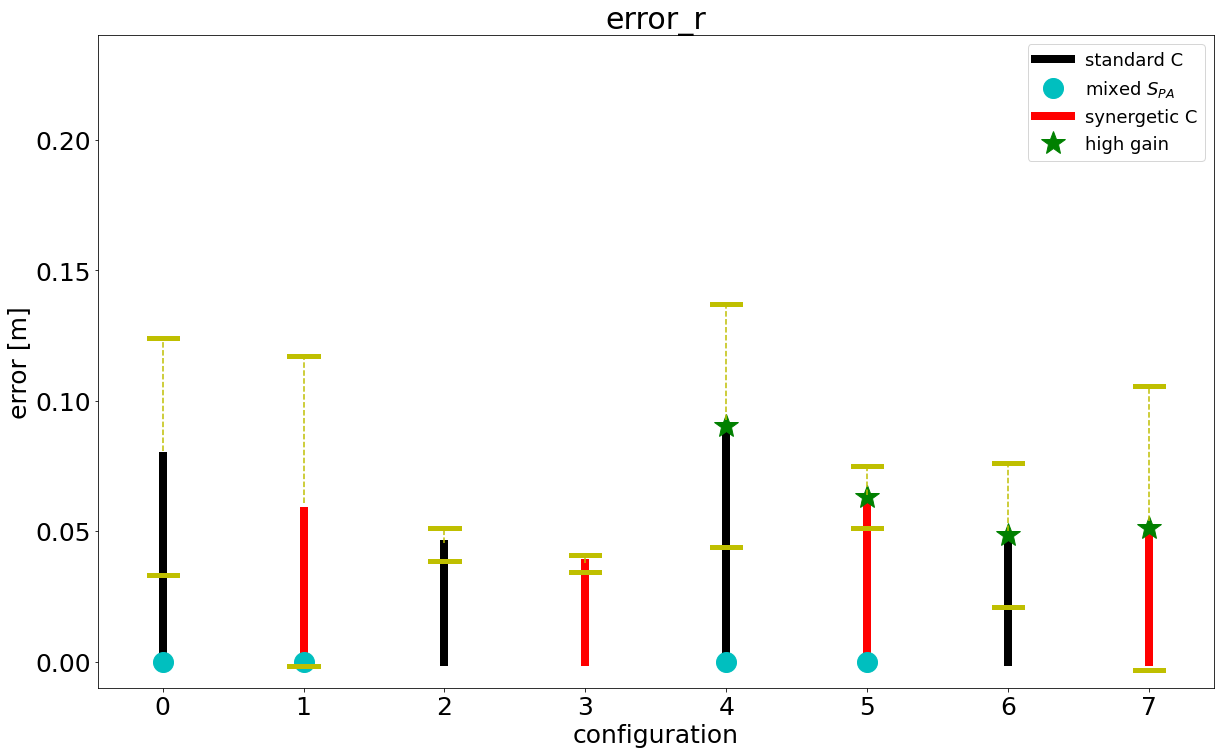

In [31]:
# For all configurations, display one value
to_disp = 'error_r'
m_fig = plt.figure(figsize=(20,12))
plt.ylim([-0.01, 0.24])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('configuration', fontsize=25)
plt.ylabel('error [m]', fontsize=25)

# quick way
# m_vals = [r[to_disp][0] for r in res_stats]
# plt.plot(m_vals, '*')
# plt.xticks(list(range(32)))

# more complete way
used_labels = []
for idx, cfg in enumerate(unique_arg_dicts):
    color2 = 'r'
#     if cfg['cfg'] == pop_gene17[0]:
#         label = '17_0'; color='k'
#     elif cfg['cfg'] == pop_gene17[1]:
#         label = '17_1'; color='y'
#     elif cfg['cfg'] == pop_gene17[2]:
#         label = '17_2'; color='b'
#     elif cfg['cfg'] == pop_gene19[0]:
#         label = '19_0'; color='c'
#     elif cfg['cfg'] == pop_gene19[1]:
#         label = '19_1'; color='g'
#     elif cfg['cfg'] == pop_gene19[2]:
#         label = '19_2'; color='m'
#     elif cfg['cfg'] == pop_pso28[0]:
#         label = '28_0'; color='r'; color2='k'
#     elif cfg['cfg'] == pop_pso28[1]:
#         label = '28_1'; color='g'; color2='y'
#     elif cfg['cfg'] == pop_pso28[2]:
#         label = '28_2'; color='w'; color2='k'
#     elif cfg['cfg'] == pop_gene25[0]:
#         label = '25_0'; color=[0.5, .1, 0.8, .1]; color2=[0.5, 0.1, 0.3, .8]
#         print('yeah')
#     elif cfg['cfg'] == pop_gene25[1]:
#         label = '25_1'; color=[0.1, 0.8, 0.1, .1]; color2=[0.1, .9, 0.1, .5]
#         print('yeah')
#     else:
#         label = 'error'; color=[0.1, 0.8, 0.1, .4]; color2=[0.1, .9, 0.9, .5]
#     if label in used_labels:
#         label = ''
#     else:
#         used_labels.append(label)
#     plt.plot([idx, idx], [0, 0.1*res_stats[idx][to_disp][0]], color=color, label=label, linewidth=6)
#     plt.plot([idx, idx], [0, 0.1*res_stats[idx][to_disp][0]], color='k', linewidth=6)
    
    avg = res_stats[idx][to_disp][0]
    std = res_stats[idx][to_disp][1]
    if cfg['use_syne']:
        if idx < 2:
            plt.plot([idx, idx], [0, avg], c=color2, label='synergetic C', linewidth=8)
        else:
            plt.plot([idx, idx], [0, avg], c=color2, linewidth=8)
    else:
        if idx < 1:
            plt.plot([idx, idx], [0, avg], 'k', label='standard C',linewidth=8)
        else:
            plt.plot([idx, idx], [0, avg], 'k', linewidth=8)
    if cfg['new_gain'] > 1.01:
        if idx < 5:
            plt.plot([idx], [avg], 'g*', markersize=25, label='high gain')
        else:
            plt.plot([idx], [avg], 'g*', markersize=25)
#     if cfg['new_noise'] > 0:
#         if idx < 5:
#             plt.plot([idx], [0], 'b^', label='noisy', markersize=15)
#         else:
#             plt.plot([idx], [0], 'b^', markersize=15)
    if cfg['rot_SPF']:
        #vals = avg * np.linspace(.1, .8, 10)
        if idx < 1:
            #plt.plot([idx]*10, vals, 'co', label='rotSPF', markersize=10)
            plt.plot([idx], [0.], 'co', label='mixed $S_{PA}$', markersize=20)
        else:
            #plt.plot([idx]*10, vals, 'co', markersize=10)
            plt.plot([idx], [0.], 'co', markersize=20)
            
    plt.plot([idx-0.1, idx+0.1], [avg-std, avg-std], 'y', linewidth=5)
    plt.plot([idx-0.1, idx+0.1], [avg+std, avg+std], 'y', linewidth=5)
    #plt.plot([idx, idx], [avg, avg-std], 'y--')
    plt.plot([idx, idx], [avg+0.05*std, avg+std], 'y--')
plt.title(to_disp, fontsize=30)
plt.legend(fontsize=18)
plt.show()

In [42]:
(np.array(res_dict_list[1]['error_r']) < 0.05).sum()

14

In [ ]:
# sort results according to a "score" value
def score_result(res):
    """ Test the properties of a simulation result.
    
        In this context, good properties (which raise the score) are:
        1* error_l and error_r are below threshold values.
        2* At least 80% of the cs_of_d values are above a threshold.
        3* n_tuned is 8 or more (assuming tuning analysis uses 12 units).
        4* pred_frac is above 0.4
        5* bimodal PD distribution
        6* max_var_per, max_orth_fr, and max_vp_of are beyond threshold values
        Args:
            res : results dictionary as returned by reach_ana.
            
        Returns:
            A score indicating the "goodness" of the simulation.
    """
    score = 0.
    if res['error_l'] < 0.1: score += 1.
    if res['error_r'] < 0.05: score += 4.
    score += 3.*(0.5 - res['error_r'])
    cod = res['cs_of_d']
    if (cod > 0.8).sum() / cod.size > 0.8: score += 1.
    if res['pred_frac'] > 0.4: score += 1.
    if res['bimodal']: score += 3.
    if res['max_var_per'] > 0.7: score += 1 + res['max_var_per']
    if res['max_orth_fr'] > 0.4: score += 1 + res['max_orth_fr']
    if res['max_vp_of'] > 0.2: score += 2 + 2 * res['max_vp_of']
        
    return score

# make sure you join the argument dictionary, or the result will be lost after sorting
for idx, result in enumerate(all_results):
    result['arg_dict'] = arg_dicts[idx]

# sort
all_results.sort(key = score_result)
    

In [ ]:
# basic info of the best configurations

# assuming this is the list of the paramter dictionaries tested
# cfg_list = [pop_gene17[0], pop_gene17[1],
#             pop_gene24[0], pop_gene24[1],
#             pop_pso24[0], pop_pso28[0]]
cfg_names = ['gene17_0', 'gene17_1',
             'gene24_0',  'gene24_1',
             'pso24_0', 'pso28_0']

all_scores = [score_result(res) for res in all_results]
cfg_name = "unidentified"
for rid in 215 - np.arange(25):
    ar = all_results[rid]
    ad = ar['arg_dict']
    for idx, cfg in enumerate(cfg_list):
        if ad['cfg'] == cfg:
            cfg_name = cfg_names[idx]
    #print('\n')
    print("%d: cfg = %s,\t use_syne = %r,\t gain = %.1f,\t noise=%.1f,\t r=%.1f,\t error_r=%.3f,\t score=%.2f" % 
          (rid, cfg_name, ad['use_syne'], ad['new_gain'], ad['new_noise'], ad['r'], ar['error_r'], all_scores[rid]))

In [13]:
for idx, result in enumerate(all_results):
    if result['bimodal']:
        print(idx)

0
1


---

In [ ]:
all_results[0]